In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, SelectFromModel, VarianceThreshold
#import xgboost
#error importing xgboost in jupyer, works if run as a script

In [3]:
#Load transformed dataframe
df = joblib.load('J:/Source/Exercises/Exercise3/modelDataset.pkl')

# Split dataframe into features and target
y = df.iloc[:, 1]  # .as_matrix()
X = df.iloc[:, 2:]  # .as_matrix()
id = df.iloc[:, 0]

In [4]:
# Scalings
sc = StandardScaler()

# Apply scaler
colNames = X.columns
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns=colNames)

In [5]:
# Remove features with less than 20% variance
colNames = X.columns
sel = VarianceThreshold(threshold=0.16)
X = sel.fit_transform(X)
# Get column names back
newCols = []
for remain, col in zip(sel.get_support(), colNames):
    if remain == True:
        newCols.append(col)
X = pd.DataFrame(X, columns=newCols)

In [6]:
# Perform univariate feature selection (ANOVA F-values)
colNames = X.columns
selection_Percent = SelectPercentile(percentile=5)
X = selection_Percent.fit_transform(X, y)
# Get column names back
newCols = []
for remain, col in zip(selection_Percent.get_support(), colNames):
    if remain == True:
        newCols.append(col)
X = pd.DataFrame(X, columns=newCols)

J:\Anaconda\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [7]:
# Perform tree-based feature selection
clf = ExtraTreesRegressor()
clf = clf.fit(X, y)
colNames = X.columns
sel = SelectFromModel(clf, prefit=True)
X = sel.transform(X)
newCols = []
for remain, col in zip(sel.get_support(), colNames):
    if remain == True:
        newCols.append(col)
X = pd.DataFrame(X, columns=newCols)

In [8]:
# Split train/testa n-au stalpi dinaa de se lower cand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [9]:
def testRegressor(clf):

    '''
    #Parameter tuning not used as is out of scope of assessment, but potential shown below
    #XGB tuning - concept, not in use
    param_grid = [{'max_depth': range(2, 4, 1),
                   'min_child_weight': range(3, 6, 1),
                   'n_estimators': range(80, 110, 10),
                   'learning_rate': [0.1],
                   'gamma': [0],
                   'subsample': [0.9, 1],
                   'colsample_bytree': [0.7],
                   'reg_alpha': [15, 50, 100, 150, 200],
                   'reg_lambda': [15, 20, 25, 30, 40, 50]}]
    fit_params = {"early_stopping_rounds": 8,
                  "eval_metric": "mae",
                  "eval_set": [[X_test, y_test]],
                  "verbose": False}
    grid = GridSearchCV(clf, param_grid, fit_params=fit_params,
                        cv=3, verbose=1, n_jobs=-1)
    fitted_classifier = grid.fit(X_train, y_train)
    print(grid.best_score_, grid.best_params_)
    predictions = fitted_classifier.predict(X_train)
    '''

    fitted = clf.fit(X_train, y_train)
    scoresCV = cross_val_score(clf, X_train, y_train, cv=10, verbose=0, n_jobs=-1)
    #trainPredictionsCV = cross_val_predict(clf, X_train, y_train, cv=10, verbose=0, n_jobs=-1)

    trainPredictions = clf.predict(X_train)
    testPredictions = clf.predict(X_test)

    score1 = metrics.explained_variance_score(y_test.values, testPredictions)
    score2 = metrics.mean_absolute_error(y_test.values, testPredictions)
    score3 = metrics.mean_squared_error(y_test.values, testPredictions)
    score4 = metrics.r2_score(y_test.values, testPredictions)
    print('Train score: ', metrics.mean_absolute_error(y_train.values, trainPredictions))
    print('CV score: ', scoresCV)
    print('Explained Variance Score, MAE, MSE, R^2')
    print(score1, score2, score3, score4)

    tempIndex = range(0, len(y_test.values), 1)
    plt.scatter(tempIndex, y_test.values, color='black', s = 20, alpha=0.8)
    plt.scatter(tempIndex, testPredictions, color='red', s = 20, alpha=0.4)
    plt.show()

Random Forest
Train score:  9.11199350032
CV score:  [ 0.98595971  0.98539685  0.98868727  0.98119416  0.98973363  0.99339532
  0.98898531  0.98607675  0.98837794  0.99014051]
Explained Variance Score, MAE, MSE, R^2
0.99028172289 20.4292688502 20031.2920225 0.990278579423


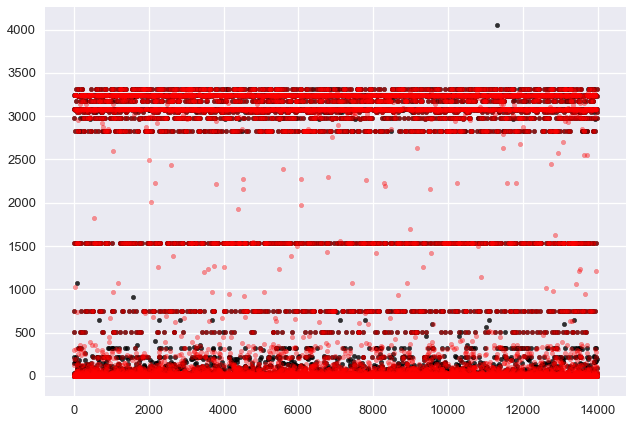

In [10]:
#lr = LinearRegression()
rf = RandomForestRegressor()
#gb = xgboost.XGBRegressor()

#print('LR')
#testRegressor(lr)
print('Random Forest')
testRegressor(rf)
#print('XGB')
#testRegressor(gb)

In [11]:
#Results appear to be highly interesting
#MSE (and thus penalising large errors more) suggests that the model does not deal well with
    #particular categories of retweets where there is a significant difference between true value and predicted
#Data appears to have high bias in terms of selection, as if tweets were selected from specific pools
    #based on retweet value
#While the random forest deals well with those particular types of tweets, more analysis is needed
#Further steps would start by understanding the sampling procedure that produced these tweets
    #From there, features need to be relooked at, dimensionality reduction (such as PCA) might be needed
    #Simpler / more powerful models to then be appropriately applied